In [115]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasdaq-100-nas100-historical-price-data/1h_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1d_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/4h_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/30m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1Month_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/5m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/15m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1w_data.csv


In [116]:
dataset = pd.read_csv("/kaggle/input/nasdaq-100-nas100-historical-price-data/15m_data.csv",delimiter = "\t")
dataset.head()

,DateTime,Open,High,Low,Close,Volume,TickVolume
0,2025.07.15 20:30:00,22961.5,22968.9,22959.9,22966.8,0,962
1,2025.07.15 20:15:00,22946.8,22964.9,22930.9,22961.6,0,4332
2,2025.07.15 20:00:00,22940.5,22973.4,22938.5,22947.0,0,4669
3,2025.07.15 19:45:00,22978.5,22994.2,22925.4,22940.9,0,4441
4,2025.07.15 19:30:00,22987.5,23002.4,22968.4,22978.5,0,4098


In [117]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201676 entries, 0 to 201675
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DateTime    201676 non-null  object 
 1   Open        201676 non-null  float64
 2   High        201676 non-null  float64
 3   Low         201676 non-null  float64
 4   Close       201676 non-null  float64
 5   Volume      201676 non-null  int64  
 6   TickVolume  201676 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 10.8+ MB


In [118]:
dataset["DateTime"] = pd.to_datetime(dataset["DateTime"])

dataset["Year"] = dataset["DateTime"].dt.year
dataset["Month"] = dataset["DateTime"].dt.month
dataset["DayOfWeek"] = dataset["DateTime"].dt.dayofweek
dataset["Day"] = dataset["DateTime"].dt.day

dataset["MA20"] = dataset["Close"].rolling(window=20).mean()
dataset["MA50"] = dataset["Close"].rolling(window=50).mean()

dataset["Daily_Return"] = dataset["Close"].pct_change()
dataset["Volatility_10"] = dataset["Close"].rolling(window = 10).std()

Text(0.5, 1.0, 'NAS100 Close Price and Moving Avegers')

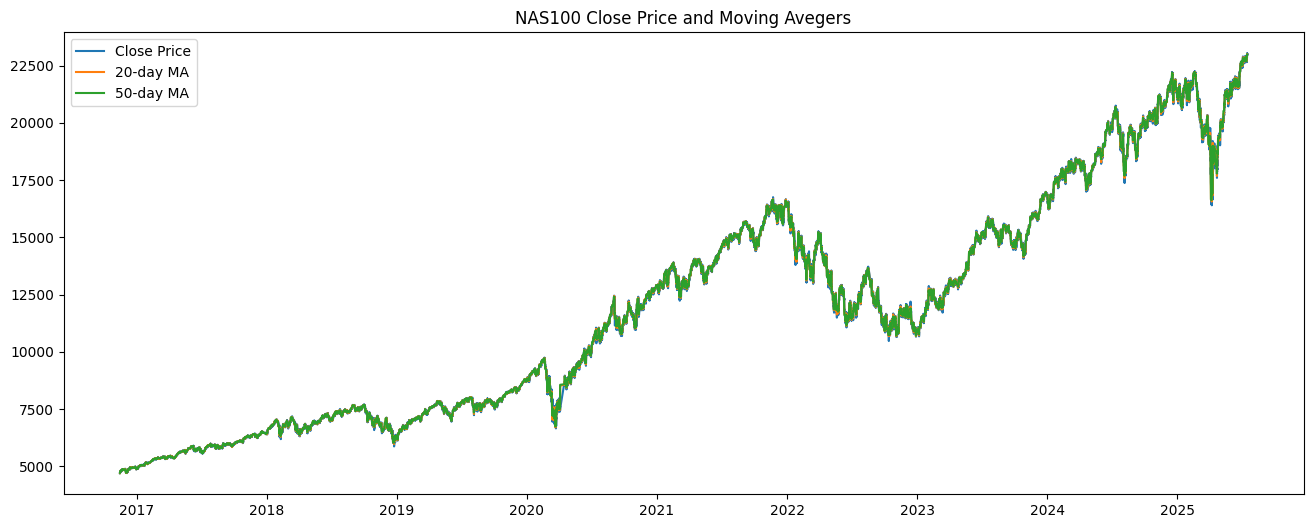

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,6))
plt.plot(dataset["DateTime"],dataset["Close"],label = "Close Price")
plt.plot(dataset["DateTime"],dataset["MA20"],label = "20-day MA")
plt.plot(dataset["DateTime"],dataset["MA50"],label = "50-day MA")
plt.legend()
plt.title("NAS100 Close Price and Moving Avegers")

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNN

dataset = dataset.drop(columns = ["DateTime","Volume"])
dataset = dataset.dropna(subset=["MA20", "MA50", "Volatility_10"])

x = dataset.drop(columns = "Close")
y = dataset["Close"]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2 ,random_state = 0)

sc = StandardScaler()
x_train_scaler = sc.fit_transform(x_train)
x_test_scaler = sc.transform(x_test)

model_list = {
    "Linear Regression" : LinearRegression(),
    "Decision Tree Refressor" : DecisionTreeRegressor(criterion ="squared_error",min_samples_split = 3,random_state = 0),
    "Random Forest Regressor" : RandomForestRegressor(n_estimators =100, min_samples_split = 3, random_state = 0),
    "SVR" : SVR(kernel  ="rbf",degree = 3,verbose = False,max_iter = 100),
    "KNN " : KNN(n_neighbors = 5,metric = "minkowski")
}


results = {}

for name,model in model_list.items():
    model.fit(x_train_scaler,y_train)
    y_pred = model.predict(x_test_scaler)
    print(f"{name}")
    print("R2 SCORE: ",r2_score(y_test,y_pred))
    print("MSE: ",mean_squared_error(y_test,y_pred))
    results[name] = y_pred
    print("*"*30)

Linear Regression
R2 SCORE:  0.999997720462231
MSE:  54.585573072056924
******************************
Decision Tree Refressor
R2 SCORE:  0.9999935310909469
MSE:  154.90381980608063
******************************
Random Forest Regressor
R2 SCORE:  0.9999967082547857
MSE:  78.82378672234935
******************************


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR
R2 SCORE:  -0.1296673898789853
MSE:  27050897.201676376
******************************
KNN 
R2 SCORE:  0.9988681784658062
MSE:  27102.480116202943
******************************


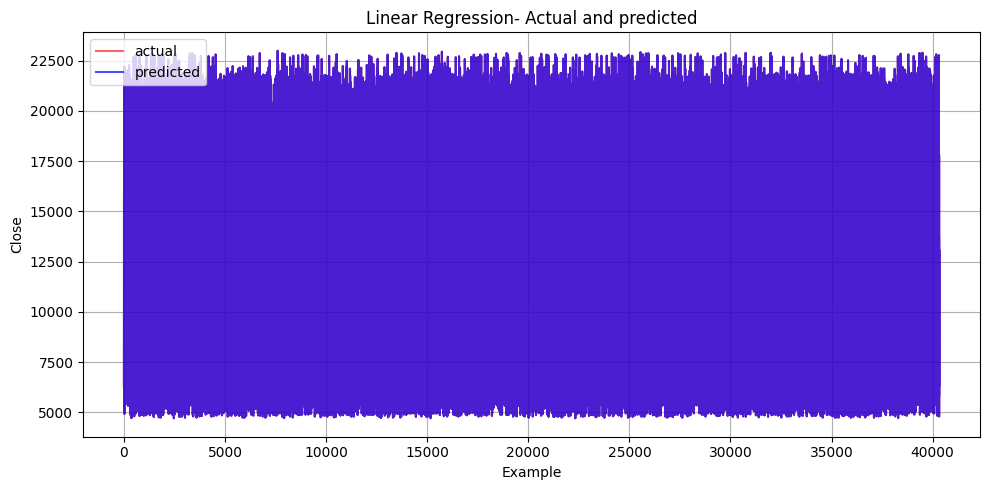

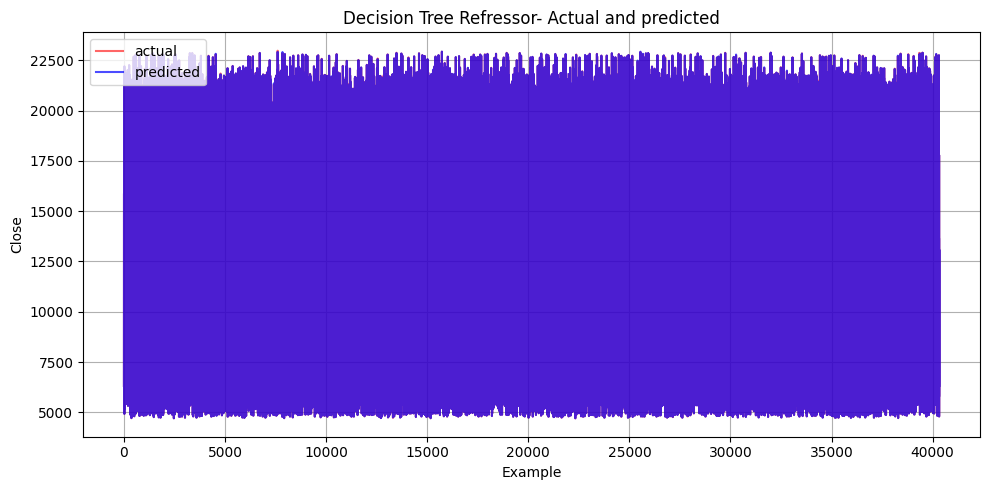

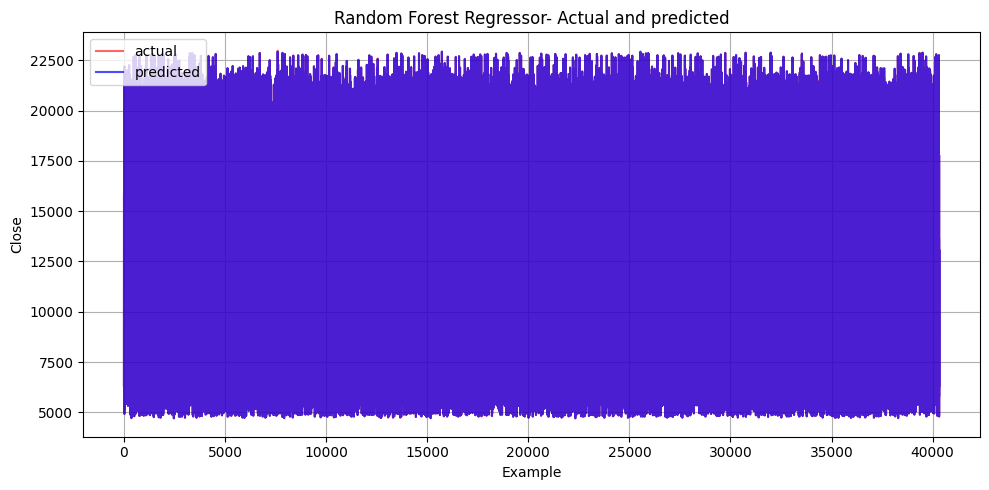

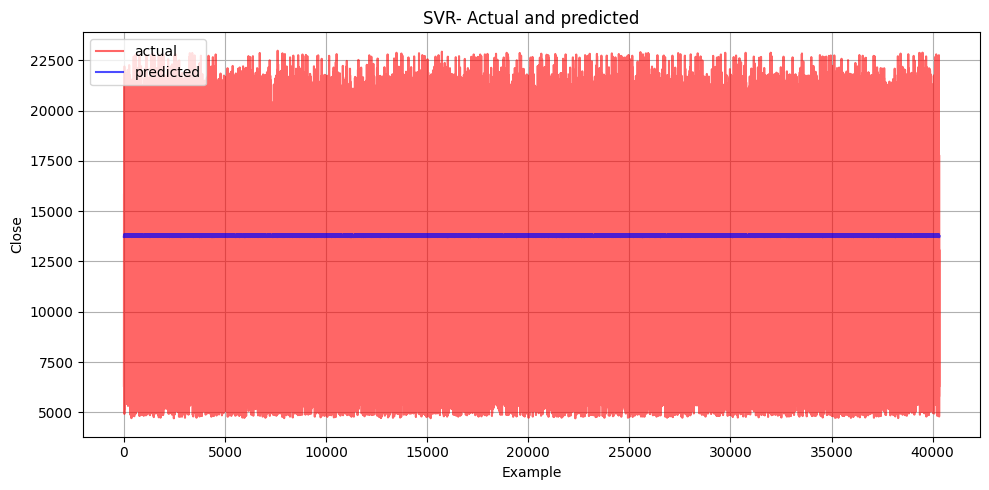

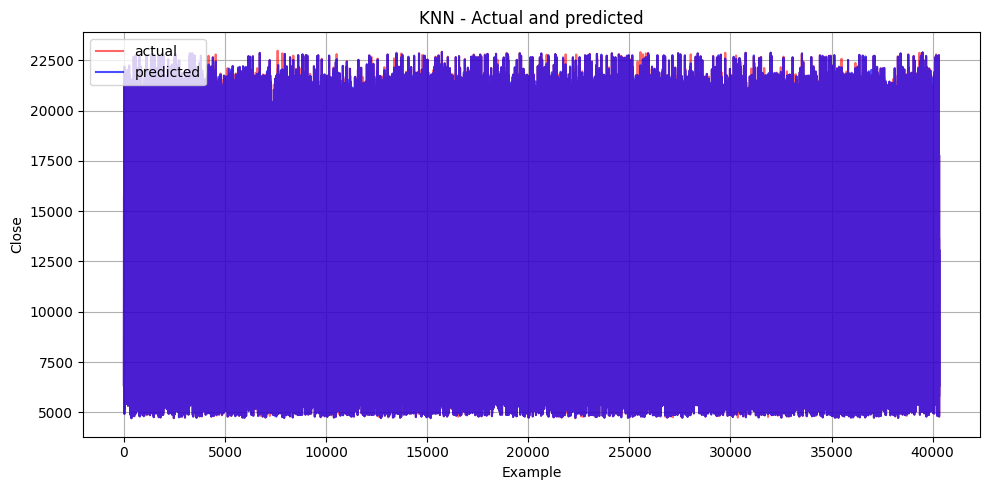

In [121]:
for name,y_pred in results.items():
    plt.figure(figsize=(10,5))
    plt.plot(y_test.reset_index(drop= True),label = "actual",color = "red",alpha = 0.6)
    plt.plot(pd.Series(y_pred),label = "predicted",color = "blue",alpha = 0.7)
    plt.title(f"{name}- Actual and predicted")
    plt.xlabel("Example")
    plt.ylabel("Close")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [122]:
from sklearn.preprocessing import MinMaxScaler

close_data = dataset[["Close"]].values
scaler = MinMaxScaler(feature_range=(0,1))
closed_scaled = scaler.fit_transform(close_data)

X = []
Y = []

window_size = 60

for i in range(window_size, len(closed_scaled)):
    X.append(closed_scaled[i-window_size:i,0])
    Y.append(closed_scaled[i,0])

X,Y = np.array(X), np.array(Y)

X = np.reshape(X,(X.shape[0],X.shape[1],1))

split = int(len(X)*0.8)
X_train, X_test = X[:split],X[split:]
Y_train, Y_test = Y[:split] , Y[split:]


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 111s 94ms/step - loss: 0.0101 - val_loss: 6.3515e-05
Epoch 2/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 104s 91ms/step - loss: 0.0012 - val_loss: 8.4889e-05
Epoch 3/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - loss: 7.1368e-04 - val_loss: 3.5271e-05
Epoch 4/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 103s 91ms/step - loss: 4.2535e-04 - val_loss: 1.8942e-05
Epoch 5/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 104s 91ms/step - loss: 3.2853e-04 - val_loss: 2.7726e-05
Epoch 6/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - loss: 3.0110e-04 - val_loss: 7.7428e-05
Epoch 7/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 104s 92ms/step - loss: 3.0815e-04 - val_loss: 8.2462e-05
Epoch 8/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 104s 91ms/step - loss: 3.0677e-04 - val_loss: 1.9640e-05
Epoch 9/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 105s 93ms/step - loss: 2.9845e-04 - val_loss: 1.7738e-06
Epoch 10/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 104s 92ms/step - loss: 2.9474e-04 - val_loss: 9.2890e-05
1260/1260 ━━━━━━━━━━━━━━━━━━

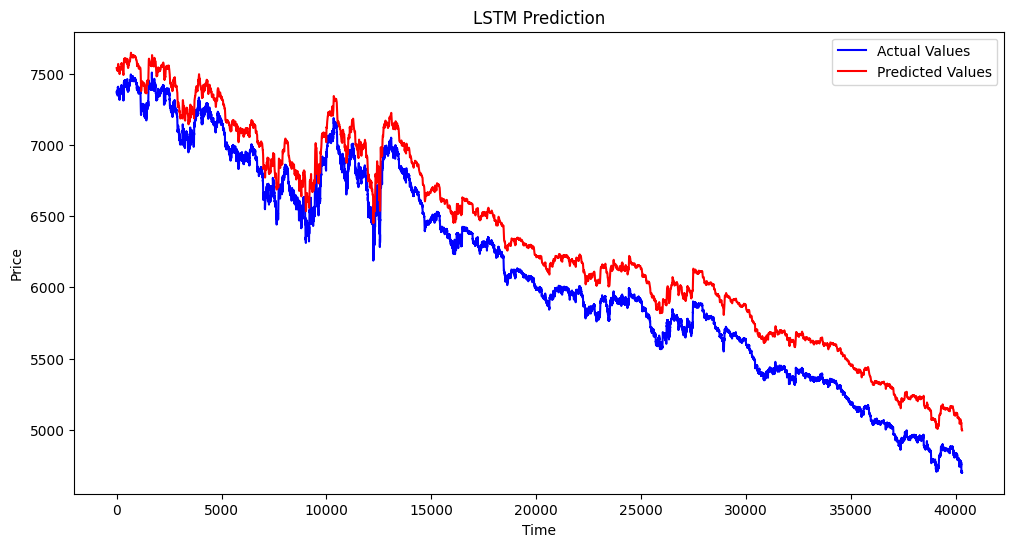

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error


model_lstm = Sequential()
model_lstm.add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1],1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer = "adam",loss = "mean_squared_error")
history_lstm = model_lstm.fit(X_train, Y_train, epochs = 10, batch_size = 128, validation_split = 0.1)

predict_lstm = model_lstm.predict(X_test)
predict_lstm = scaler.inverse_transform(predict_lstm.reshape(-1,1))
y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

print("📈 LSTM Model Performance:")
print("LSTM R2 SCORE: ",r2_score(y_test_inv,predict_lstm))
print("LSTM MSE: ", mean_squared_error(y_test_inv,predict_lstm))

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, color="blue", label="Actual Values")
plt.plot(predict_lstm, color="red", label="Predicted Values")
plt.title("LSTM Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 114s 95ms/step - loss: 0.0106 - val_loss: 9.3077e-05
Epoch 2/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - loss: 0.0012 - val_loss: 1.4496e-05
Epoch 3/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 108s 96ms/step - loss: 7.1760e-04 - val_loss: 7.3182e-06
Epoch 4/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 108s 96ms/step - loss: 4.2926e-04 - val_loss: 7.0616e-05
Epoch 5/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 109s 96ms/step - loss: 3.2114e-04 - val_loss: 3.5052e-05
Epoch 6/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 108s 96ms/step - loss: 2.9554e-04 - val_loss: 1.2298e-05
Epoch 7/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 109s 96ms/step - loss: 2.9180e-04 - val_loss: 6.4559e-05
Epoch 8/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 109s 96ms/step - loss: 2.9754e-04 - val_loss: 9.0744e-05
Epoch 9/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 108s 95ms/step - loss: 2.8916e-04 - val_loss: 3.1944e-06
Epoch 10/10
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 109s 96ms/step - loss: 2.8358e-04 - val_loss: 2.9709e-05
1260/1260 ━━━━━━━

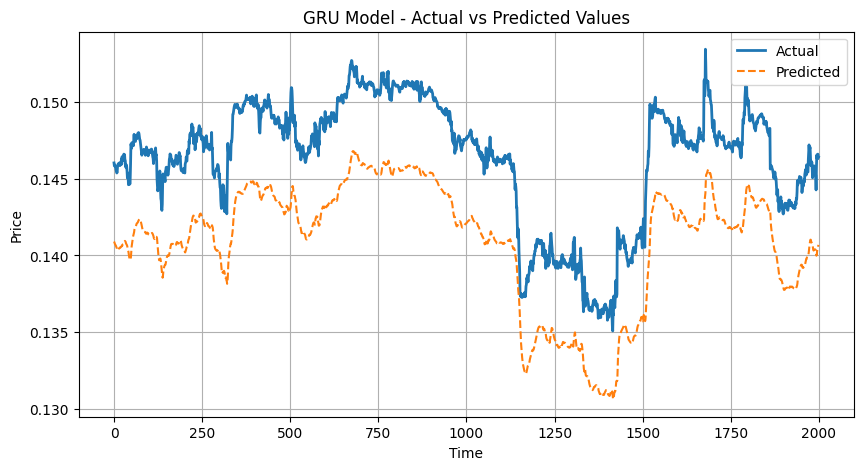

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam


model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1))


model_gru.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")


history_gru = model_gru.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


y_pred_gru = model_gru.predict(X_test)


r2_gru = r2_score(Y_test, y_pred_gru)
mse_gru = mean_squared_error(Y_test, y_pred_gru)

print("📈 GRU Model Performance:")
print("R2 SCORE:", r2_gru)
print("MSE:", mse_gru)


plt.figure(figsize=(10, 5))
plt.plot(Y_test[:2000], label="Actual", linewidth=2)
plt.plot(y_pred_gru[:2000], label="Predicted", linestyle="--")
plt.title("GRU Model - Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
